In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import scipy.stats as stats
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import random
from sklearn.utils.class_weight import compute_class_weight

### First and foremost, merge two dbs into one

In [2]:
train_transaction = pd.read_csv("data/train_transaction.csv")
train_identity = pd.read_csv("data/train_identity.csv")

# Merge both dataframes on 'TransactionID'
train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")

print(f"Rows in merged training set: {train.shape[0]}")
print(f"Columns in merged training set: {train.shape[1]}")
train.head()

Rows in merged training set: 590540
Columns in merged training set: 434


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Perform an initial exploratory data analysis (EDA) by checking missing value percentages and examining the target distribution.

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Identifying the target variable distribution and missing values for features

Missing percentages per column:
id_24            99.196159
id_25            99.130965
id_07            99.127070
id_08            99.127070
id_21            99.126393
id_26            99.125715
id_27            99.124699
id_23            99.124699
id_22            99.124699
dist2            93.628374
D7               93.409930
id_18            92.360721
D13              89.509263
D14              89.469469
D12              89.041047
id_03            88.768923
id_04            88.768923
D6               87.606767
id_33            87.589494
id_10            87.312290
id_09            87.312290
D9               87.312290
D8               87.312290
id_30            86.865411
id_32            86.861855
id_34            86.824771
id_14            86.445626
V142             86.123717
V158             86.123717
V140             86.123717
V162             86.123717
V141             86.123717
V161             86.123717
V157             86.123717
V146             86.123717
V156             86.123

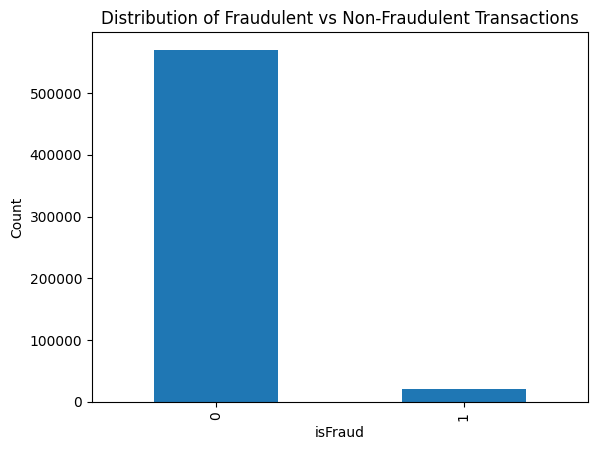

In [4]:
# Missing value percentages per column
missing_percent = (train.isnull().sum() / len(train)) * 100
missing_percent = missing_percent.sort_values(ascending=False)
print("Missing percentages per column:")
print(missing_percent[missing_percent > 0])

# Distribution of the target variable 'isFraud'
train['isFraud'].value_counts().plot(kind='bar')
plt.title("Distribution of Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

In [5]:
null_cols = [col for col in train.columns if train[col].isna().sum() > 0.9 * len(train)]
null_cols

['dist2',
 'D7',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

In [6]:
missing_df = train.copy(deep=True)
for col in null_cols:
    missing_df["m_flag_"+col] = np.where(missing_df[col].isnull(), 1, 0)
    correlation = missing_df[["m_flag_"+col, 'isFraud']].corr()
    print(correlation)


              m_flag_dist2   isFraud
m_flag_dist2      1.000000 -0.091096
isFraud          -0.091096  1.000000
           m_flag_D7   isFraud
m_flag_D7   1.000000 -0.164478
isFraud    -0.164478  1.000000
              m_flag_id_07   isFraud
m_flag_id_07      1.000000 -0.024333
isFraud          -0.024333  1.000000
              m_flag_id_08   isFraud
m_flag_id_08      1.000000 -0.024333
isFraud          -0.024333  1.000000
              m_flag_id_18   isFraud
m_flag_id_18      1.000000 -0.074815
isFraud          -0.074815  1.000000
              m_flag_id_21  isFraud
m_flag_id_21       1.00000 -0.02431
isFraud           -0.02431  1.00000
              m_flag_id_22   isFraud
m_flag_id_22      1.000000 -0.024252
isFraud          -0.024252  1.000000
              m_flag_id_23   isFraud
m_flag_id_23      1.000000 -0.024252
isFraud          -0.024252  1.000000
              m_flag_id_24   isFraud
m_flag_id_24      1.000000 -0.024345
isFraud          -0.024345  1.000000
              m_flag_i

In [7]:
categorical_features = train.select_dtypes(include=['object', 'category']).columns
for col in categorical_features:
    print(col, len(set(train[col])), set(train[col]))

ProductCD 5 {'H', 'S', 'W', 'R', 'C'}
card4 5 {'american express', 'visa', 'discover', 'mastercard', nan}
card6 5 {'debit', 'charge card', nan, 'credit', 'debit or credit'}
P_emaildomain 60 {'charter.net', 'icloud.com', 'yahoo.com.mx', 'outlook.es', 'servicios-ta.com', 'web.de', 'aim.com', 'mail.com', 'centurylink.net', 'outlook.com', nan, 'aol.com', 'att.net', 'embarqmail.com', 'optonline.net', 'protonmail.com', 'verizon.net', 'anonymous.com', 'q.com', 'comcast.net', 'bellsouth.net', 'windstream.net', 'frontiernet.net', 'ymail.com', 'suddenlink.net', 'juno.com', 'cox.net', 'yahoo.co.uk', 'live.com.mx', 'yahoo.co.jp', 'netzero.com', 'sc.rr.com', 'roadrunner.com', 'yahoo.com', 'cfl.rr.com', 'yahoo.de', 'sbcglobal.net', 'msn.com', 'frontier.com', 'mac.com', 'gmail.com', 'gmail', 'hotmail.es', 'hotmail.de', 'cableone.net', 'twc.com', 'ptd.net', 'hotmail.co.uk', 'yahoo.fr', 'rocketmail.com', 'live.fr', 'gmx.de', 'me.com', 'earthlink.net', 'yahoo.es', 'hotmail.fr', 'prodigy.net.mx', 'netzer

### Find truly categorical values

Screen resolution values are true numerical values, while all other features are categorical in nature

In [8]:
train[['Screen_Width', 'Screen_Height']] = train['id_33'].str.split('x', expand=True).astype(float)
train = train.drop(columns=['id_33'])

In [9]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns

# Identify candidate categorical features based on unique value counts
candidate_categorical = {}
# Set a threshold for maximum unique values
unique_threshold = 20

# Iterate over numeric columns to check unique value counts
for col in train.select_dtypes(include=['int64', 'float64']).columns:
    unique_vals = train[col].nunique()
    if unique_vals < unique_threshold and col != "isFraud":
        candidate_categorical[col] = unique_vals

# Print candidate categorical features
print("Candidate categorical features (numeric columns with few unique values):")
for col, count in candidate_categorical.items():
    print(f"{col}: {count} unique values")

Candidate categorical features (numeric columns with few unique values):
V1: 2 unique values
V2: 9 unique values
V3: 10 unique values
V4: 7 unique values
V5: 7 unique values
V6: 10 unique values
V7: 10 unique values
V8: 9 unique values
V9: 9 unique values
V10: 5 unique values
V11: 6 unique values
V12: 4 unique values
V13: 7 unique values
V14: 2 unique values
V15: 8 unique values
V16: 15 unique values
V17: 16 unique values
V18: 16 unique values
V19: 8 unique values
V20: 15 unique values
V21: 6 unique values
V22: 9 unique values
V23: 14 unique values
V24: 14 unique values
V25: 7 unique values
V26: 13 unique values
V27: 4 unique values
V28: 4 unique values
V29: 6 unique values
V30: 8 unique values
V31: 8 unique values
V32: 15 unique values
V33: 7 unique values
V34: 13 unique values
V35: 4 unique values
V36: 6 unique values
V39: 16 unique values
V40: 18 unique values
V41: 2 unique values
V42: 9 unique values
V43: 9 unique values
V46: 7 unique values
V47: 9 unique values
V48: 6 unique value

### Imputing nulls

Not using standard imputation:
1. Placed zero values as indicator for missing values where feature values no zero values anywhere else
2. Added 'missing' instead of null for categorical values to keep all the columns

In [10]:
# Identify numeric and categorical columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = list(set(cat_cols).union(set(candidate_categorical.keys())))
num_cols = [col for col in num_cols if col not in cat_cols and col not in ("TransactionID", "isFraud")]

# Imputation for numeric columns using zeros as indicator
num_imputer = SimpleImputer(strategy='constant', fill_value=0)
train[num_cols] = num_imputer.fit_transform(train[num_cols])

# Imputation for categorical columns using a constant value
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])

# Confirm that no missing values remain (or check overall missing count)
print("Total missing values after imputation:", train.isnull().sum().sum())

Total missing values after imputation: 0


### Data encoding

In [12]:
X = train.drop(columns=["isFraud", "TransactionID"])
y = train['isFraud']

### Encoding categorical features

Splitting train and test asap

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Using novel thing: WOE encoder to compensate for an enormous dimentionality for SVC

In [13]:
encoder_high = ce.WOEEncoder(cols=cat_cols)
X_train_encoded_cat = encoder_high.fit_transform(X_train[cat_cols], y_train)
X_test_encoded_cat = encoder_high.transform(X_test[cat_cols])

### Data normalization

Scale data to remove any disrepancies in SVC

In [14]:
scaler = StandardScaler()
X_train_scaled_num = scaler.fit_transform(X_train[num_cols])
X_test_scaled_num = scaler.transform(X_test[num_cols])

In [15]:
X_train_scaled = pd.DataFrame(np.hstack([X_train_encoded_cat.values, X_train_scaled_num]), columns=cat_cols + num_cols)
X_test_scaled = pd.DataFrame(np.hstack([X_test_encoded_cat.values, X_test_scaled_num]), columns=cat_cols + num_cols)

In [16]:
print("Encoded training set shape:", X_train_scaled.shape)
print("Encoded test set shape:", X_test_scaled.shape)

Encoded training set shape: (472432, 433)
Encoded test set shape: (118108, 433)


In [17]:
X_train_scaled.head()

,V123,V109,V40,V125,V260,V6,V250,V42,id_24,card4,V53,V79,V59,V119,V29,P_emaildomain,V304,V67,V111,V72,V300,V88,V115,V57,V116,V65,M8,V15,V3,ProductCD,V121,V2,V91,id_35,V175,V51,V74,V117,id_04,id_31,V39,V84,V184,V301,V70,id_34,V93,M4,V5,V52,V251,V13,V286,V1,V48,V62,V7,V63,V64,id_30,V33,V120,V173,V73,V25,V305,V141,V58,V71,V76,id_23,V288,M3,M7,V11,V17,V154,V153,V174,V112,DeviceType,V69,V21,V223,id_38,V60,V75,V24,M1,V107,V325,id_27,V22,V18,M9,V4,V328,V9,V110,V41,V124,V49,V47,V34,V68,V195,V14,V36,V83,V82,V8,V19,V55,id_32,V46,V297,V85,V197,V284,id_36,V10,M6,V54,V94,V241,V16,V114,V89,V142,V104,V43,id_18,V30,V61,V28,V108,V327,V302,V12,id_15,V27,M5,R_emaildomain,id_28,M2,id_12,V66,id_37,V194,card6,V23,V247,V26,V289,V50,id_29,id_16,V113,V31,V32,V98,V240,V92,V118,V122,V20,V35,V90,DeviceInfo,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V37,V38,V44,V45,V56,V77,V78,V80,V81,V86,V87,V95,V96,V97,V99,V100,V101,V102,V103,V105,V106,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V176,V177,V178,V179,V180,V181,V182,V183,V185,V186,V187,V188,V189,V190,V191,V192,V193,V196,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V242,V243,V244,V245,V246,V248,V249,V252,V253,V254,V255,V256,V257,V258,V259,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V285,V287,V290,V291,V292,V293,V294,V295,V296,V298,V299,V303,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V326,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_21,id_22,id_25,id_26,Screen_Width,Screen_Height
0,-0.085018,-0.033529,0.028950,-0.086159,0.708125,0.410700,0.644286,0.028950,-0.01215,-0.142730,0.531234,0.325713,0.531234,-0.010113,0.383795,-0.395075,0.802900,0.531234,-0.035588,0.531234,-0.026793,0.325713,-0.045227,0.531234,-0.046097,0.531234,0.275416,0.383795,0.410700,0.090415,-0.004744,0.410700,0.325713,0.243019,0.827610,0.028950,0.531234,-0.009943,1.174202,-0.612598,0.02895,0.325713,0.719326,-0.036066,0.531234,0.106197,0.325713,-0.653040,0.410700,0.028950,0.610189,0.383795,-0.005473,0.410700,0.028950,0.531234,0.410700,0.531234,0.531234,-0.063873,0.383795,-0.004153,0.872048,0.531234,0.383795,-0.000099,0.174927,0.531234,0.531234,0.325713,-0.012757,-0.077195,0.423702,0.275378,0.41070,0.383795,0.031686,0.069703,0.829283,-0.03759,0.652664,0.531234,0.383795,0.836027,0.542538,0.531234,0.325713,0.383795,0.423702,-0.000195,0.237782,-0.012757,0.383795,0.383795,0.275416,0.410700,0.190160,0.410700,-0.034195,0.02895,-0.073621,0.028950,0.028950,0.383795,0.531234,0.531945,0.383795,0.028950,0.325713,0.325713,0.410700,0.383795,0.531234,-0.043298,0.028950,-0.017537,0.325713,0.553973,-0.060493,0.894744,0.41070,0.737784,0.531234,0.325713,0.843918,0.383795,-0.043011,0.325713,0.173348,-0.024835,0.02895,-0.121683,0.383795,0.531234,0.383795,-0.033578,0.216208,0.827407,0.383795,1.165839,0.383795,0.066966,-0.169704,1.142724,0.423702,0.893194,0.531234,0.915791,0.553973,0.682454,0.383795,0.702588,0.383795,-0.080630,0.02895,1.161001,1.187974,-0.036001,0.383795,0.383795,-0.038494,0.843236,0.325713,-0.009934,-0.004764,0.383795,0.028950,0.325713,-1.080841,-1.378728,-0.145302,-0.759998,0.257853,-0.203484,-1.078432,0.042876,0.360192,-0.196545,-0.094803,-0.098434,-0.092693,-0.039137,-0.030306,-0.215803,-0.113225,-0.046189,-0.032914,-0.268532,-0.033820,-0.098328,-0.047102,-0.236331,-0.147581,3.269944,3.383160,-0.323817,-0.576067,-0.309651,-0.155767,-0.099152,6.159508,2.726051,-0.616023,

### Save data

In [18]:
X_train_scaled.to_csv("data/preprocessed_train.csv", index=False)
X_test_scaled.to_csv("data/preprocessed_test.csv", index=False)

### Baseline SVC

Download data

In [11]:
X_train_scaled = pd.read_csv("data/preprocessed_train.csv")
X_test_scaled = pd.read_csv("data/preprocessed_test.csv")

Train baseline model

In [17]:
class_weights = dict(zip(np.unique(y_train), compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)))

In [ ]:
model = SVC(kernel="rbf", C=1.0, class_weight=class_weights, random_state=42)
model.fit(X_train_scaled, y_train)
print("Model training is finished")
y_pred = model.predict(X_test_scaled)
print("Baseline model Accuracy:", accuracy_score(y_test, y_pred))

### GA for input features subset selection

In [ ]:
def run_genetic_algorithm(X_data, y_data, population_size=30, n_generations=5, subset_size=20):
    n_features = X_data.shape[1]
    
    # Initialize population - each individual is a sorted list of feature indices
    population = []
    for _ in range(population_size):
        subset = random.sample(range(n_features), subset_size)
        subset.sort()
        population.append(subset)
    
    def fitness(individual):
        # Train SVC with this subset and return average cross-validation accuracy
        X_subset = X_data.iloc[:, individual]
        model = SVC(kernel="rbf")
        scores = cross_val_score(model, X_subset, y_data, cv=3, scoring='accuracy')
        return scores.mean()
    
    # Crossover combines genes from both parents at a random cut point
    def crossover(p1, p2, subset_size):
        cut = random.randint(1, subset_size - 1)
        return p1[:cut] + p2[cut:]

    # Mutation replaces a random index in child if random.threshold is met
    def mutation(child, n_features, subset_size):
        if random.random() < 0.1:
            i = random.randrange(subset_size)
            child[i] = random.randrange(n_features)
        return child

    for _ in range(n_generations):
        # Evaluate fitness of population
        scored_population = [(fitness(ind), ind) for ind in population]
        scored_population.sort(key=lambda x: x[0], reverse=True)
        
        # Selection: truncation selection (pick top half as survivors)
        survivors = scored_population[: population_size // 2]
        
        # Then randomly select two parents (p1 & p2) from survivors for crossover + mutation
        new_pop = [s[1] for s in survivors]
        while len(new_pop) < population_size:
            p1 = random.choice(survivors)[1]
            p2 = random.choice(survivors)[1]
            child = crossover(p1, p2, subset_size)
            child = mutation(child, n_features, subset_size)
            
            child = list(set(child))  # remove duplicates if any
            while len(child) < subset_size:  # if duplicates reduced size
                child.append(random.randrange(n_features))
            child.sort()
            new_pop.append(child)
        population = new_pop
    
    best = max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1]
    return best

best_features = run_genetic_algorithm(X_train, y_train)
X_train_ga = X_train.iloc[:, best_features]
X_test_ga = X_test.iloc[:, best_features]
model = SVC(kernel="rbf")
model.fit(X_train_ga, y_train)
y_pred = model.predict(X_test)
print("Model accuracy with selected features:", accuracy_score(y_test, y_pred))

### PSO and ACO for SVC hyperparameter tuning

In [ ]:
def run_pso_for_hyperparams(X_data, y_data, model_class, n_particles=10, n_iterations=5):
    # Define parameter search space for SVC (C and gamma)
    c_min, c_max = 0.01, 10.0
    gamma_min, gamma_max = 1e-4, 1.0

    # Initialize particles (positions) and velocities randomly
    positions = [
        [random.uniform(c_min, c_max), random.uniform(gamma_min, gamma_max)]
        for _ in range(n_particles)
    ]
    velocities = [[0.0, 0.0] for _ in range(n_particles)]

    # Personal bests (pbest) and global best (gbest)
    pbest_positions = positions[:]
    pbest_scores = [0.0]*n_particles
    gbest_position = None
    gbest_score = 0.0

    def fitness(pos):
        candidate = model_class(C=pos[0], gamma=pos[1], kernel='rbf')
        scores = cross_val_score(candidate, X_data, y_data, cv=3, scoring='accuracy')
        return scores.mean()

    # Evaluate initial fitness
    for i in range(n_particles):
        current_score = fitness(positions[i])
        pbest_scores[i] = current_score
        if current_score > gbest_score:
            gbest_score = current_score
            gbest_position = positions[i][:]

    # Main PSO loop
    w = 0.5  # inertia
    c1 = 1.0 # cognitive
    c2 = 1.0 # social
    for _ in range(n_iterations):
        for i in range(n_particles):
            # Velocity update
            r1, r2 = random.random(), random.random()
            velocities[i][0] = (
                w*velocities[i][0]
                + c1*r1*(pbest_positions[i][0] - positions[i][0])
                + c2*r2*(gbest_position[0] - positions[i][0])
            )
            velocities[i][1] = (
                w*velocities[i][1]
                + c1*r1*(pbest_positions[i][1] - positions[i][1])
                + c2*r2*(gbest_position[1] - positions[i][1])
            )
            
            # Position update and boundary check
            positions[i][0] += velocities[i][0]
            positions[i][1] += velocities[i][1]
            positions[i][0] = max(c_min, min(c_max, positions[i][0]))
            positions[i][1] = max(gamma_min, min(gamma_max, positions[i][1]))

            # Evaluate fitness
            current_score = fitness(positions[i])
            if current_score > pbest_scores[i]:
                pbest_scores[i] = current_score
                pbest_positions[i] = positions[i][:]
                if current_score > gbest_score:
                    gbest_score = current_score
                    gbest_position = positions[i][:]

    return {"C": gbest_position[0], "gamma": gbest_position[1], "kernel": "rbf"}

best_params = run_pso_for_hyperparams(X_train_ga, y_train, SVC)
model_pso = SVC(**best_params)
model_pso.fit(X_train_ga, y_train)
y_pred_pso = model_pso.predict(X_test_ga)
print("PSO-tuned model Accuracy:", accuracy_score(y_test, y_pred_pso))

In [ ]:
def run_aco_for_hyperparams(X_data, y_data, model_class, n_ants=10, n_iterations=5):
    # Define parameter search space for SVC (C and gamma)
    c_min, c_max = 0.01, 10.0
    gamma_min, gamma_max = 1e-4, 1.0

    # Initialize pheromone levels for discrete “bins” in each dimension
    n_bins = 10
    pheromones = [[1.0 for _ in range(n_bins)] for _ in range(n_bins)]

    def bin_to_value(bin_index, min_val, max_val):
        step_size = (max_val - min_val) / n_bins
        return min_val + bin_index * step_size + (step_size / 2)

    def fitness(c_val, gamma_val):
        candidate = model_class(C=c_val, gamma=gamma_val, kernel='rbf')
        scores = cross_val_score(candidate, X_data, y_data, cv=3, scoring='accuracy')
        return scores.mean()

    best_score = 0.0
    best_params = (1.0, 1e-3)

    for _ in range(n_iterations):
        solutions = []
        for _ant in range(n_ants):
            # Select bins for C, gamma by roulette wheel sampling of pheromones
            c_bin = random.choices(range(n_bins), weights=pheromones[0], k=1)[0]
            g_bin = random.choices(range(n_bins), weights=pheromones[1], k=1)[0]
            c_val = bin_to_value(c_bin, c_min, c_max)
            gamma_val = bin_to_value(g_bin, gamma_min, gamma_max)
            
            score = fitness(c_val, gamma_val)
            solutions.append((c_bin, g_bin, score))

        # Update pheromones
        # Evaporate
        for i in range(n_bins):
            for j in range(len(pheromones)):
                pheromones[j][i] *= 0.9

        # Deposit
        for (c_bin, g_bin, score) in solutions:
            if score > best_score:
                best_score = score
                best_params = (bin_to_value(c_bin, c_min, c_max),
                               bin_to_value(g_bin, gamma_min, gamma_max))
            pheromones[0][c_bin] += score
            pheromones[1][g_bin] += score

    return {"C": best_params[0], "gamma": best_params[1], "kernel": "rbf"}

best_params_aco = run_aco_for_hyperparams(X_train_ga, y_train, SVC)
model_aco = SVC(**best_params_aco)
model_aco.fit(X_train_ga, y_train)
y_pred_aco = model_aco.predict(X_test_ga)
print("ACO-tuned model Accuracy:", accuracy_score(y_test, y_pred_aco))

### PSO and ACO for SVC loss function convergence speedup

In [ ]:
# hell no we're not doing this